# Miniproject 1: Image Classification

## Introduction

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://deeplearning.net/tutorial/logreg.html). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that was [recently extended](https://arxiv.org/abs/1702.05373). We break with this tradition (just a little bit) and tackle first the related problem of classifying cropped, downsampled and grayscaled images of house numbers in the [The Street View House Numbers (SVHN) Dataset](http://ufldl.stanford.edu/housenumbers/).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook.

### Your names

Before you start, please enter your full name(s) in the field below; they are used to load the data. The variable student2 may remain empty, if you work alone.

In [57]:
student1 = "Simão Sarmento"
SCIPER1 = 284660
student2 = "Dennis Gankin"
SCIPER2 = 284089

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [58]:
#%matplotlib inline
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io


import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from keras.optimizers import SGD, Adam
from keras.layers.normalization import BatchNormalization
from keras import backend as K

np.random.seed(SCIPER1 + SCIPER2)
subset_of_classes = np.random.choice(range(10), 5, replace = False)

In [59]:
subset_of_classes

array([3, 0, 1, 7, 9])

### Plotting

In [60]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 16, ydim = 16,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    #plt.close()
    #return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    #fig.tight_layout()
    plt.subplots_adjust(top=1.2)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    plt.close()
    finalize_standardplot(fig, ax1, ax2)
    return fig

def plot_comparison(histories, optimizers, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    for idx, history in enumerate(histories):
        ax1.plot(history.history['loss'], label = "training "+ optimizers[idx])
        ax1.plot(history.history['val_loss'], label = "validation " + optimizers[idx])
        ax2.plot(history.history['acc'], label = "training "+optimizers[idx])
        ax2.plot(history.history['val_acc'], label = "validation "+optimizers[idx])
    plt.close()
    finalize_standardplot(fig, ax1, ax2)
    return fig

def box_plot(data, title, labels, model_labels):
    '''
    Function to plot a Box Plot
    :param data - List with loss and accuracy data ([0] and [1])
    :param title - Plot title
    :param labels - List with axis labels 
    :param model_labels - List with model labels
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,7))
    fig.suptitle(title)
    # set labels
    ax1.set_xlabel(labels[0])
    ax2.set_xlabel(labels[0])
    ax1.set_ylabel(labels[1])
    ax2.set_ylabel(labels[2])
    # adjust size
    fig.subplots_adjust(wspace=0.3)
    # plotting...
    ax1.boxplot(data[0], labels = model_labels)
    ax2.boxplot(data[1], labels = model_labels)

### Loading and preprocessing the data

The data consists of RGB color images with 32x32 pixels, loaded into an array of dimension 32x32x3x(number of images). We convert them to grayscale (using [this method](https://en.wikipedia.org/wiki/SRGB#The_reverse_transformation)) and we downsample them to images of 16x16 pixels by averaging over patches of 2x2 pixels.

With these preprocessing steps we obviously remove some information that could be helpful in classifying the images. But, since the processed data is much lower dimensional, the fitting procedures converge faster. This is an advantage in situations like this (or generally when prototyping), where we want to try many different things without having to wait too long for computations to finish. After having gained some experience, one may want to go back to work on the 32x32 RGB images.


In [61]:
# convert RGB images x to grayscale using the formula for Y_linear in https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-preserving)_conversion_to_grayscale
def grayscale(x):
    # normalization is performed
    x = x.astype('float32')/255
    x = np.piecewise(x, [x <= 0.04045, x > 0.04045], 
                        [lambda x: x/12.92, lambda x: ((x + .055)/1.055)**2.4])
    return .2126 * x[:,:,0,:] + .7152 * x[:,:,1,:]  + .07152 * x[:,:,2,:]

def downsample(x):
    return sum([x[i::2,j::2,:] for i in range(2) for j in range(2)])/4

def preprocess(data):
    gray = grayscale(data['X'])
    downsampled = downsample(gray)
    return (downsampled.T, downsampled.reshape(16*16, gray.shape[2]).transpose(),
            data['y'].flatten() - 1)

data_train = scipy.io.loadmat('housenumbers/train_32x32.mat')
data_test = scipy.io.loadmat('housenumbers/test_32x32.mat')

x_train_original_all, x_train_all, y_train_all = preprocess(data_train)
x_test_original_all, x_test_all, y_test_all = preprocess(data_test)

### Shaping data as desired

In [62]:
img_rows = 16
img_cols = 16

if K.image_data_format() == 'channels_first':
    x_train_original_all = x_train_original_all.reshape(x_train_original_all.shape[0], 1, img_rows, img_cols)
    x_test_original_all = x_test_original_all.reshape(x_test_original_all.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train_original_all = x_train_original_all.reshape(x_train_original_all.shape[0], img_rows, img_cols, 1)
    x_test_original_all = x_test_original_all.reshape(x_test_original_all.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
x_train_original_all = x_train_original_all.astype('float32')
x_test_original_all = x_test_original_all.astype('float32')
print('x_train_original_all shape:', x_train_original_all.shape)
print('x_test_original_all shape:', x_test_original_all.shape)

x_train_original_all shape: (73257, 16, 16, 1)
x_test_original_all shape: (26032, 16, 16, 1)


### Selecting a subset of classes

We further reduce the size of the dataset (and thus reduce computation time) by selecting only the 5 (out of 10 digits) in subset_of_classes.

In [120]:
def extract_classes(x_original, x_flat, y, classes):
    indices = []
    labels = []
    count = 0
    for c in classes:
        tmp = np.where(y == c)[0]
        #print('tmp : ', tmp)
        indices.extend(tmp)
        labels.extend(np.ones(len(tmp), dtype='uint8') * count)
        count += 1
    return x_original[indices], x_flat[indices], labels

x_train_original, x_train, labels_train = extract_classes(x_train_original_all, x_train_all, y_train_all, subset_of_classes)
x_test_original, x_test, labels_test = extract_classes(x_test_original_all, x_test_all, y_test_all, subset_of_classes)

Let us plot some examples now. The green digit at the bottom left of each image indicates the corresponding label in y_test.
For further usage of the function plot_some_samples, please have a look at its definition in the plotting section.

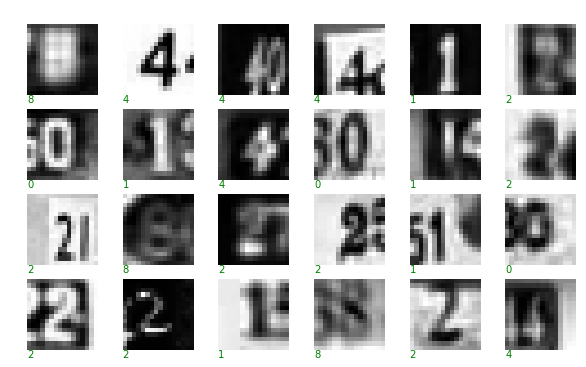

In [64]:
plot_some_samples(x_test, labels_test, label_mapping = subset_of_classes);

To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing).

In [121]:
y_train = keras.utils.to_categorical(labels_train)
y_test = keras.utils.to_categorical(labels_test)

## Exercise 1: No hidden layer

### Description

Define and fit a model without a hidden layer. 

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)`


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

**Paramters Definition:**

In [66]:
activation_fct = 'softmax'
neurons = 5
loss_fct = 'categorical_crossentropy'
metrics = ['accuracy']
optimizer = 'SGD'
batch_size = 128
epochs = 200

**Create Model:**

In [67]:
def singlelayer_nn(activation_fct, input_dim, loss_fct, metrics, neurons, optimizer):
    '''
    :param activation_fct - activation function for output layer
    :param: input_dim - input dimension
    :param neurons - number of neurons for output layer
    :param loss_fct - loss function to use
    :param optimizer - type of optimizer
    :param metrics - measuring metrics
    '''
    # initialize sequential model
    model = Sequential()
    # add output layer
    model.add(Dense(neurons, input_dim = input_dim, activation=activation_fct))
    # compile model...
    model.compile(loss= loss_fct, optimizer=optimizer, metrics=metrics)
    # print summary
    model.summary()
    
    return model

In [68]:
# creating model
model = singlelayer_nn(activation_fct, 256, loss_fct, metrics, neurons, optimizer)

# fitting
start = time.time()
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data = (x_test, y_test),
                    verbose=0)
# the end
end = time.time()

print('Model take %0.2f seconds to train'%(end-start))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_203 (Dense)            (None, 5)                 1285      
Total params: 1,285
Trainable params: 1,285
Non-trainable params: 0
_________________________________________________________________
Model take 197.22 seconds to train


**Check performance:**

In [69]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.512217545281525
Test accuracy: 0.4004612850111831


**Fitting Procedure Plot**

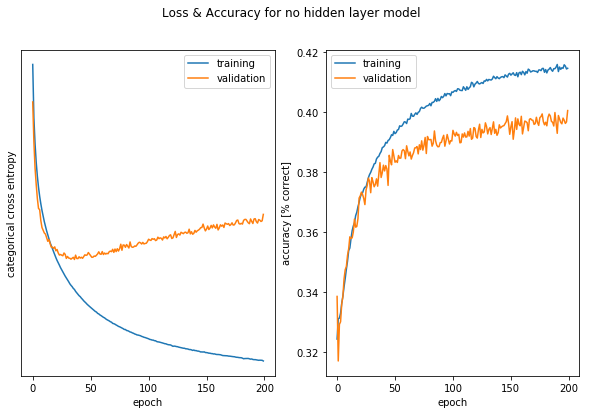

In [70]:
plot_history(history, 'Loss & Accuracy for no hidden layer model')

In the figure above we can clearly observe what is called the elbow effect, given the shape of the validation loss curve. 

**Misclassified**

Predictions are calculated as follows:

In [71]:
yhat_test = model.predict(x_test)

Detecting error indices...

In [72]:
labels_hat = np.asarray([np.argmax(yhat_test[i]) for i in range(len(yhat_test))])
labels_test = np.asarray([np.argmax(y_test[i]) for i in range(len(y_test))])

error_indices = np.where(labels_hat != labels_test)[0]

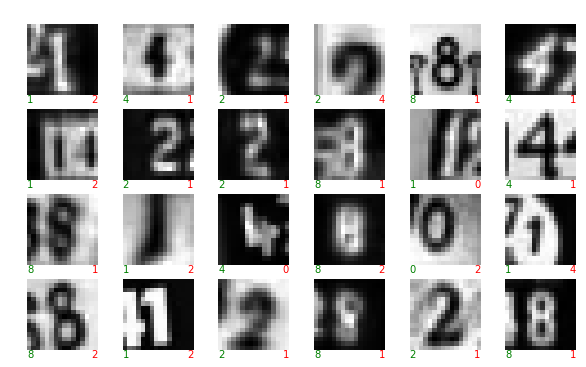

In [73]:
plot_some_samples(x_test, y_test, yhat_test, error_indices, label_mapping = subset_of_classes)

## Exercise 2: One hidden layer, different optizimizers
### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 64 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to inspect your model.
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent and answer the question below.
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam).
4. Plot the learning curves of SGD with a reasonable learning rate together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot.

### Solution

**Paramters Definition:**

In [74]:
activation_per_layer = ['relu','softmax']
neurons_per_layer = [64,5]
loss_fct = 'categorical_crossentropy'
metrics = ['accuracy']
batch_size = 128
epochs = 50

**Create Model:**

In [75]:
def hiddenlayer_nn(activation_per_layer, input_dim, loss_fct, metrics, neurons_per_layer, optimizer):
    '''
    :param: input_dim - input dimension
    :param neurons_per_layer - list of neurons in each layer
    :param activation_per_layer - list of activation functions in each layer
    :param loss_fct - loss function to use
    :param optimizer - type of optimizer
    :param metrics - measuring metrics
    '''
    # initialize sequential model
    model = Sequential()
    # fill layers (different for first layer -> need to specify input dim)
    for i in range(len(neurons_per_layer)):
        if i == 0:
            model.add(Dense(neurons_per_layer[i], input_dim = input_dim, activation=activation_per_layer[i]))
        else:
            model.add(Dense(neurons_per_layer[i], activation = activation_per_layer[i]))
    # complile model
    model.compile(loss= loss_fct, optimizer=optimizer, metrics=metrics)
    # print summary
    model.summary()
    
    return model

**Testing SGD w/ different learning rates:**

In [76]:
learning_rates = [0.001, 0.1, 10]
history_sgd = []
for lr in learning_rates:
    # define sgd optimizer with specific learning rate
    sgd = SGD(lr = lr)
    # create model
    model = hiddenlayer_nn(activation_per_layer, 256, loss_fct, metrics, neurons_per_layer, sgd)
    # fit model
    history = model.fit(np.asarray(x_train), y_train,
                        validation_data = (x_test, y_test),
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0)
    # test model
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss for lr = {}: {}'.format(lr, score[0]))
    print('Test accuracy for lr = {}: {}'.format(lr, score[1])) 
    
    history_sgd.append(history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_204 (Dense)            (None, 64)                16448     
_________________________________________________________________
dense_205 (Dense)            (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss for lr = 0.001: 1.448298341705536
Test accuracy for lr = 0.001: 0.37799011532125204
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_206 (Dense)            (None, 64)                16448     
_________________________________________________________________
dense_207 (Dense)            (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
________________________________________

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence (double click this markdown cell to edit).

**Answer**:

A) For larger learning rates, the step per iteration is excessively big, and it jumps over the minima we are trying to reach, ie. we overshoot, and the minimium might not ever be reached (divergence).

B) For a smaller learning rate, less information is learned per epoch. Thus, more epochs are required in order to learn a good model, for this specific dataset, 0.001 shows to be a too small learning rate. 

**Testing Adam Optimizer**

In [77]:
# create model
model = hiddenlayer_nn(activation_per_layer, 256, loss_fct, metrics, neurons_per_layer, 'adam')
# fit model
history_adam = model.fit(np.asarray(x_train), y_train,
                         validation_data = (x_test, y_test),
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=0)
# test model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss for Adam Optimizer: {}'.format(score[0]))
print('Test accuracy for Adam Optimizer: {}'.format(score[1]))    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_210 (Dense)            (None, 64)                16448     
_________________________________________________________________
dense_211 (Dense)            (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss for Adam Optimizer: 0.4757874455129884
Test accuracy for Adam Optimizer: 0.8759802306464319


**Plotting...**

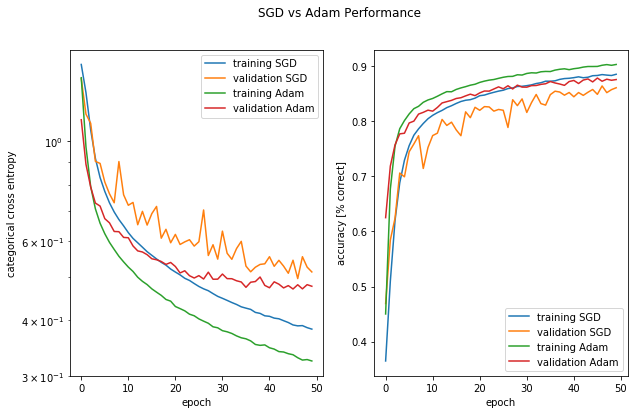

In [78]:
plot_comparison([history_sgd[1], history_adam], ['SGD', 'Adam'], 'SGD vs Adam Performance')

## Exercise 3: Overfitting and early stopping with Adam

### Description

Run the above simulation with Adam for sufficiently many epochs (be patient!) until you see clear overfitting.

1. Plot the learning curves of a fit with Adam and sufficiently many epochs and answer the questions below.

A simple, but effective mean to avoid overfitting is early stopping, i.e. a fit is not run until convergence but stopped as soon as the validation error starts to increase. We will use early stopping in all subsequent exercises.

### Solution

**Parameters Definition:**

In [79]:
activation_per_layer = ['relu','softmax']
neurons_per_layer = [64,5]
loss_fct = 'categorical_crossentropy'
metrics = ['accuracy']
batch_size = 128
epochs = 200
optimizer = 'adam'

**Training...**

In [80]:
# create model
model = hiddenlayer_nn(activation_per_layer, 256, loss_fct, metrics, neurons_per_layer, optimizer)
# fit model
history_overfitted = model.fit(np.asarray(x_train), y_train,
                               validation_data = (x_test, y_test),
                               batch_size=batch_size,
                               epochs=epochs,
                               verbose=0)
# test model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss for Adam Optimizer: {}'.format(score[0]))
print('Test accuracy for Adam Optimizer: {}'.format(score[1]))  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_212 (Dense)            (None, 64)                16448     
_________________________________________________________________
dense_213 (Dense)            (None, 5)                 325       
Total params: 16,773
Trainable params: 16,773
Non-trainable params: 0
_________________________________________________________________
Test loss for Adam Optimizer: 0.5310084919540651
Test accuracy for Adam Optimizer: 0.8865238879775686


**Plotting...**

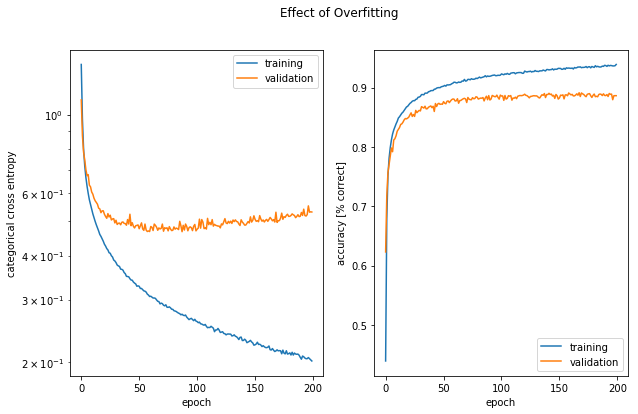

In [81]:
plot_history(history_overfitted, 'Effect of Overfitting')

**Question 1**: At which epoch (approximately) does the model start to overfit? Please answer with one full sentence.

**Answer**: The model starts to overfit after approximately 70 epochs, when the categorial cross entropy of the validation data starts to rise again.

**Question 2**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: One can notice that the accuracy of the training data augments and converges to 1 while for the validation data it rises to a certain point and then stays at a constant level when the model is overfitting. The loss is reduced with more epochs and the training data converges to 0 while the loss on the validation set reaches a minimum and then starts rising again when the model starts overfitting. While accuracy stays constant when overfitting the loss gets bigger again from the point when overfitting starts, which proves the need for "early stopping".

## Exercise 4: Model performance as a function of number of hidden neurons

### Description

Investigate how the best validation loss and accuracy depend on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models with different hidden layer size (between 10 and 1000 hidden neurons) for a fixed number of epochs well beyond the point of overfitting.
2. Collect some statistics by fitting the same models as in 1. for multiple initial conditions. Hints: 1. If you don't reset the random seed, you get different initial conditions each time you create a new model. 2. Let your computer work while you are asleep.
3. Plot summary statistics of the final validation loss and accuracy versus the number of hidden neurons. Hint: [boxplots](https://matplotlib.org/examples/pylab_examples/boxplot_demo.html) (also [here](https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.boxplot.html?highlight=boxplot#matplotlib.axes.Axes.boxplot)) are useful. You may also want to use the matplotlib method set_xticklabels.
4. Plot summary statistics of the loss and accuracy for early stopping versus the number of hidden neurons.

### Solution

**Parameters Definition:**

In [82]:
activation_per_layer = ['relu','softmax']
neurons_per_layer = [[10,5], [100, 5],[500, 5], [1000, 5]]
loss_fct = 'categorical_crossentropy'
metrics = ['accuracy']
batch_size = 128
epochs = 200
optimizer = 'adam'
n_initial_conditions = 5

**Fitting for different number of hidden neurons...**

Initialize storage lists:

In [83]:
# array to store loss and acc values
loss_per_model = []
acc_per_model = []

# array to store loss and acc values with early stopping
loss_per_model_es = []
acc_per_model_es = []

# array to store one history per model, for plot purposes
histories_1HL = []

In [84]:
for neurons in neurons_per_layer:
    # inner loop for different initial conditions
    # -- seed is not resetted
    # -- each time a model is initializated, we get different initial conditions
    # no early stopping
    loss_per_init = []
    acc_per_init = []
    # with early stopping
    loss_per_init_es = []
    acc_per_init_es = []
    for initial_i in range(n_initial_conditions):
        # create model
        model = hiddenlayer_nn(activation_per_layer, 256, loss_fct, metrics, neurons, 'adam')
        # fit model
        history = model.fit(np.asarray(x_train), y_train,
                            validation_data = (x_test, y_test),
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0)
        
        # store loss and accuracy without early stopping
        loss_per_init.append(history.history['val_loss'][-1])
        acc_per_init.append(history.history['val_acc'][-1])
        
        # get minimium loss index
        es_idx = history.history['val_loss'].index(min(history.history['val_loss']))
        # store loss and accuracy with early stopping
        loss_per_init_es.append(history.history['val_loss'][es_idx])
        acc_per_init_es.append(history.history['val_acc'][es_idx])
        
    # append one history object per model - for plotting purposes
    histories_1HL.append(history)
    
    # append loss and accuracy values to use for Box Plot:
    # -- with early stopping -- 
    loss_per_model_es.append(loss_per_init_es)
    acc_per_model_es.append(acc_per_init_es)
    # --without early stopping--
    loss_per_model.append(loss_per_init)
    acc_per_model.append(acc_per_init)
    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_214 (Dense)            (None, 10)                2570      
_________________________________________________________________
dense_215 (Dense)            (None, 5)                 55        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_216 (Dense)            (None, 10)                2570      
_________________________________________________________________
dense_217 (Dense)            (None, 5)                 55        
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_242 (Dense)            (None, 500)               128500    
_________________________________________________________________
dense_243 (Dense)            (None, 5)                 2505      
Total params: 131,005
Trainable params: 131,005
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_244 (Dense)            (None, 1000)              257000    
_________________________________________________________________
dense_245 (Dense)            (None, 5)                 5005      
Total params: 262,005
Trainable params: 262,005
Non-trainable params: 0
_________________________________________________________________
________________________________________________________________

**Box Plotting**

We express the variability due to different initial conditions with the following Box Plots:

*Box plot without early stopping*

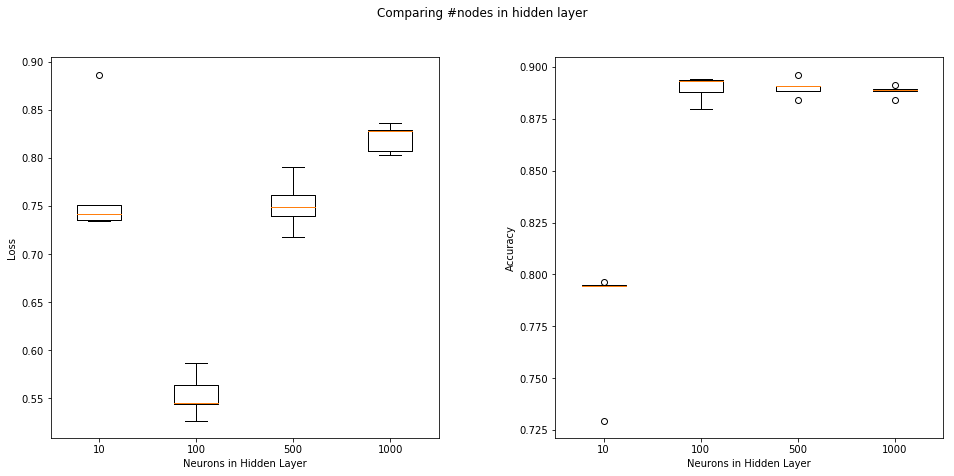

In [85]:
box_plot([loss_per_model, acc_per_model], 'Comparing #nodes in hidden layer',
         ['Neurons in Hidden Layer','Loss', 'Accuracy'], ['10', '100', '500','1000'])

*Box plot with early stopping*

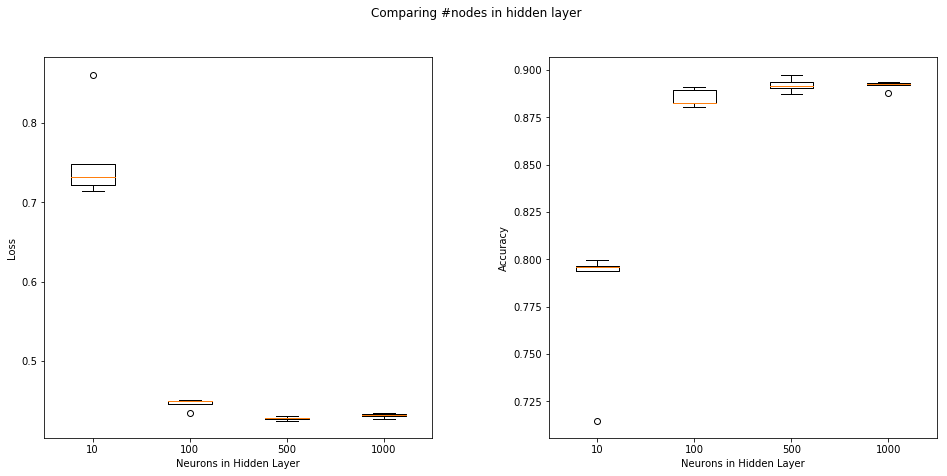

In [86]:
box_plot([loss_per_model_es, acc_per_model_es], 'Comparing #nodes in hidden layer',
         ['Neurons in Hidden Layer','Loss', 'Accuracy'], ['10', '100', '500','1000'])

# CAN WE REMOVE THIS?
**Plotting for different number of hidden nodes**

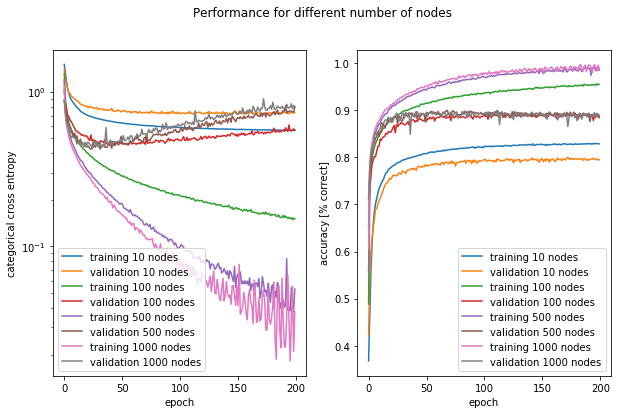

In [87]:
plot_comparison(histories_1HL, ['10 nodes', '100 nodes', '500 nodes','1000 nodes'], 'Performance for different number of nodes')

## Exercise 5: Comparison to deep models

### Description

Instead of choosing one hidden layer (with many neurons) you experiment here with multiple hidden layers (each with not so many neurons).

1. Fit models with 2, 3 and 4 hidden layers with approximately the same number of parameters as a network with one hidden layer of 100 neurons. Hint: Calculate the number of parameters in a network with input dimensionality N_in, K hidden layers with N_h units, one output layer with N_out dimensions and solve for N_h. Confirm you result with the keras method model.summary().
2. Run each model multiple times with different initial conditions and plot summary statistics of the best validation loss and accuracy versus the number of hidden layers.

### Solution

If we assume that each layer has the same amount of neurons.

***number of parameters*** $ = (N_{in}+1)\cdot N_h + (K-1)\cdot (N_h+1)\cdot N_h + (N_h+1)\cdot N_{out}$

Therefore, for $ N_{in} = 256, N_h =100, K = 1, N_{out} = 5$, we get **26205 parameters**.

Thus:

K=2:  N_h = 77

K=3:  N_h = 66

K=4   N_h = 59

In [88]:
activation_per_layer = [['relu','relu','softmax'],['relu','relu','relu','softmax'],
                        ['relu','relu','relu','relu','softmax']]
neurons_per_layer = [[77,77,5], [66,66,66,5], [59,59,59,59, 5]]
loss_fct = 'categorical_crossentropy'
metrics = ['accuracy']
batch_size = 128
epochs = 200
optimizer = 'adam'
n_initial_conditions = 5

Initialize storage lists...

In [89]:
# array to store loss and acc values with early stopping
loss_per_model_es = []
acc_per_model_es = []

# array to store one history per model, for plot purposes
histories_MHL = []

In [90]:
for i,neurons in enumerate(neurons_per_layer):
    # inner loop for different initial conditions
    # -- seed is not resetted
    # -- each time a model is initializated, we get different initial conditions
    # with early stopping
    loss_per_init_es = []
    acc_per_init_es = []
    for initial_i in range(n_initial_conditions):
        # create model
        model = hiddenlayer_nn(activation_per_layer[i], 256, loss_fct, metrics, neurons, 'adam')
        # fit model
        history = model.fit(np.asarray(x_train), y_train,
                            validation_data = (x_test, y_test),
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0)
        
        # get minimium loss index
        es_idx = history.history['val_loss'].index(min(history.history['val_loss']))
        # store loss and accuracy with early stopping
        loss_per_init_es.append(history.history['val_loss'][es_idx])
        acc_per_init_es.append(history.history['val_acc'][es_idx])

    # append one history object per model - for plotting purposes
    histories_MHL.append(history)
    
    # append loss and accuracy values to use for Box Plot:
    # -- with early stopping -- 
    loss_per_model_es.append(loss_per_init_es)
    acc_per_model_es.append(acc_per_init_es)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_254 (Dense)            (None, 77)                19789     
_________________________________________________________________
dense_255 (Dense)            (None, 77)                6006      
_________________________________________________________________
dense_256 (Dense)            (None, 5)                 390       
Total params: 26,185
Trainable params: 26,185
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_257 (Dense)            (None, 77)                19789     
_________________________________________________________________
dense_258 (Dense)            (None, 77)                6006      
_________________________________________________________________
dense_

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_294 (Dense)            (None, 59)                15163     
_________________________________________________________________
dense_295 (Dense)            (None, 59)                3540      
_________________________________________________________________
dense_296 (Dense)            (None, 59)                3540      
_________________________________________________________________
dense_297 (Dense)            (None, 59)                3540      
_________________________________________________________________
dense_298 (Dense)            (None, 5)                 300       
Total params: 26,083
Trainable params: 26,083
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_

**Box Plotting**

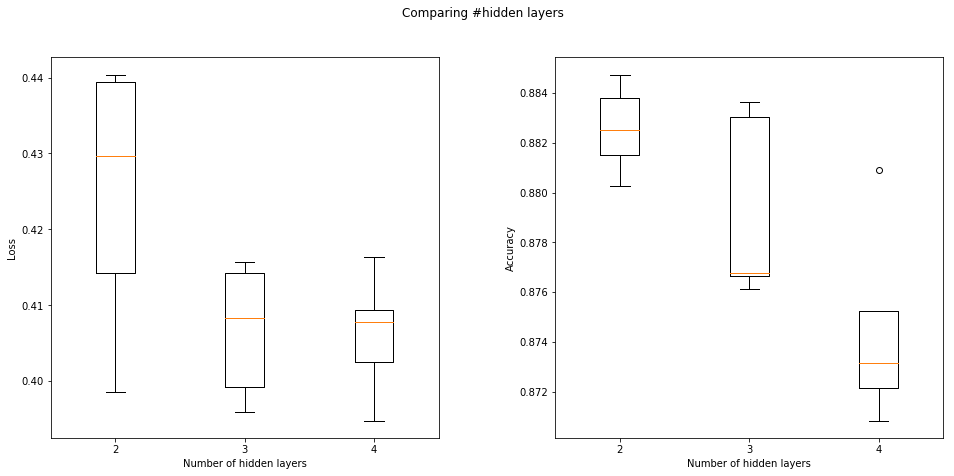

In [91]:
box_plot([loss_per_model_es, acc_per_model_es], 'Comparing #hidden layers',
         ['Number of hidden layers','Loss', 'Accuracy'], ['2', '3', '4'])

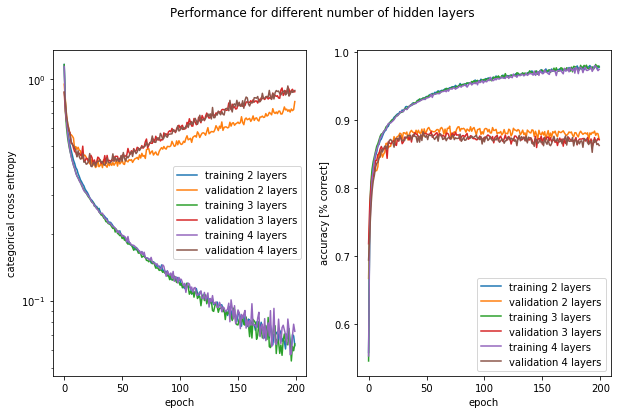

In [92]:
plot_comparison(histories_MHL, ['2 layers', '3 layers', '4 layers'], 'Performance for different number of hidden layers')

## Exercise 6: Tricks (regularization, batch normalization, dropout)

### Description

Overfitting can also be counteracted with regularization and dropout. Batch normalization is supposed to mainly decrease convergence time.

1. Try to improve the best validation scores of the model with 1 layer and 100 hidden neurons and the model with 4 hidden layers. Experiment with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases.
2. After you have found good settings, plot for both models the learning curves of the naive model you fitted in the previous exercises together with the learning curves of the current version.
3. For proper comparison, plot also the learning curves of the two current models in a third figure.

### Solution

**Basic Parameters:**

In [93]:
from keras import regularizers 
from keras.constraints import maxnorm
from keras.layers import Activation

def build_regularized_nn(input_dim, neurons_per_layer, activation_per_layer,
                         batch_normalization, dropout_per_layer , weight_reg=None, 
                         bias_reg = None,maxn=4):
    '''
    Function to build neural net performing
    regularization at different levels.
    :param: input_dim - input dimension
    :param neurons_per_layer - list of neurons in each layer
    :param activation_per_layer - list of activation functions in each layer
    :param batch_normalization - boolean that indicates whether to perform batch_normalization or not
    :param dropout_per_layer - dropout probability per layer
    :param l1_regularizer - value for l1 regularizer
    :param l2_regularizer - value for l2 regularizer
    '''
    
    #activity regularizer for output 
    #bias_reguilarizer same as b_regularizer
    #kernel regularizer for weights same as W_regularizer
    #use kernel_initializer='he_uniform',?
    
    
    # define basic parameters
    batch_size = 128; epochs = 200; optimizer = 'adam'; 
    loss_fct = 'categorical_crossentropy'; metrics = ['accuracy']    
    
    # initialize sequential model
    model = Sequential()    
    
    # fill layers (different for first layer -> need to specify input dim)
    for layer in range(len(neurons_per_layer)):
        if layer == 0:
            if maxn:
                model.add(Dense(neurons_per_layer[layer], input_dim = input_dim,
                                kernel_constraint=maxnorm(maxn),kernel_regularizer=weight_reg,bias_regularizer=bias_reg))
            else:
                model.add(Dense(neurons_per_layer[layer], input_dim = input_dim,
                                kernel_regularizer=weight_reg,bias_regularizer=bias_reg))
                
        else:
            if maxn:
                model.add(Dense(neurons_per_layer[layer],
                            kernel_constraint=maxnorm(maxn),kernel_regularizer=weight_reg,bias_regularizer=bias_reg))
            else:
                model.add(Dense(neurons_per_layer[layer],
                            kernel_regularizer=weight_reg,bias_regularizer=bias_reg))
        
        # add batch normalization
        if batch_normalization:
                model.add(BatchNormalization())       
        # add activation
        model.add(Activation(activation_per_layer[layer]))
        # add dropout except for output layer
        if layer != (len(neurons_per_layer) - 1):
            model.add(Dropout(dropout_per_layer[layer]))
            
    # complile model
    model.compile(loss= loss_fct, optimizer=optimizer, metrics=metrics)
    
    # fitting
    history = model.fit(np.asarray(x_train), y_train,
                            validation_data = (x_test, y_test),
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=0)
        
    # get minimium loss index
    es_idx = history.history['val_loss'].index(min(history.history['val_loss']))
    # store loss and accuracy with early stopping
    loss = history.history['val_loss'][es_idx]
    acc = history.history['val_acc'][es_idx]
    
    return history, loss, acc

**`Batch Normalization`:**

Is not obvious where to apply the batch normalization: while the authors of batch normalisation suggest performing it before applying the activation function of the neuron (on the computed linear combinations of the input data), [recently published results](https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md) suggest that it might be more beneficial (and at least as good) to do it after. 

We tried both, and obtained better results when applying before the activation function. For this reason, we will follow on with the first approach.

**`Dropout layers`:**

For our dropout, we will base our tuning at this [paper](http://jmlr.org/papers/v15/srivastava14a.html). Several common tips to improve the performance are explored. In short, we will take this into account:
- Use small dropout value of 20%-50% of neurons with 20% providing a good starting point. A probability too low has minimal effect and a value too high results in under-learning by the network.
- Use dropout on incoming (visible) as well as hidden units. Application of dropout at each layer of the network has shown good results.
- Constrain the size of network weights. A large learning rate can result in very large network weights. Imposing a constraint on the size of network weights such as max-norm regularization with a size of 4 or 5 has been shown to improve results. For this purpose, tha application of the l2-regulizer will prove to be useful.

**`L1 regularization`:**

We will apply L1 regularization both in the `bias` and `weights`.

**`L2 regularization`:**

We will apply L2 regularization both in the `bias` and `weights`.

**Start tunning...**

We will test the following combinations of regularizers:
1. Batch
2. Dropout 
    2.1 20%
    2.2 35%
    2.3 50%
3. L1 regularization
    3.1 for weights
    3.2 for bias
4. L2 regularization
    4.1 for weights
    4.2 for bias
5. L1 + L2
6. Dropout+Batch
7. Dropout+bacth+L2+L1

Define storage variables...

In [94]:
'''
** Nomenclature **
K1_N100 - 1 hidden layer, 100 Nodes
K4_N59 - 4 hidden layers, 59 Nodes each
'''
K1_N100 = []
K4_N59 = []


# 1. Batch Normalization - 0
K1_N100.append(build_regularized_nn(256, [100,5], ['relu','softmax'],batch_normalization = True,
                                    dropout_per_layer = [0,0]))
K4_N59.append(build_regularized_nn(256,[59,59,59,59, 5] ,['relu','relu','relu','relu','softmax'],
                                   batch_normalization = True, dropout_per_layer = [0,0,0,0]))
print ("1")

# 2.1. Dropout (0.2) - 1
K1_N100.append(build_regularized_nn(256, [100,5], ['relu','softmax'],
                                    batch_normalization = False, dropout_per_layer = [0.2,0.2],maxn=4))
K4_N59.append(build_regularized_nn(256,[59,59,59,59, 5] ,['relu','relu','relu','relu','softmax'],
                                   batch_normalization = False, dropout_per_layer = [0.2,0.2,0.2,0.2],maxn=4))
print("2.1")

# 2.2 Dropout 0.35 - 2
K1_N100.append(build_regularized_nn(256, [100,5], ['relu','softmax'],
                                    batch_normalization = False, dropout_per_layer = [0.35,0.35],maxn=4)) 
K4_N59.append(build_regularized_nn(256,[59,59,59,59, 5] ,['relu','relu','relu','relu','softmax'],
                                   batch_normalization = False, dropout_per_layer = [0.35,0.35,0.35,0.35],maxn=4))
print("2.2")
# 2.3. Dropout (0.5) - 3
K1_N100.append(build_regularized_nn(256, [100,5], ['relu','softmax'],
                                    batch_normalization = False, dropout_per_layer = [0.5,0.5],maxn=4))
K4_N59.append(build_regularized_nn(256,[59,59,59,59, 5] ,['relu','relu','relu','relu','softmax'],
                                   batch_normalization = False, dropout_per_layer = [0.5,0.5,0.5,0.5],maxn=4))
print("2.3")

# 3.1 l1 regularizer on weigths - 4
K1_N100.append(build_regularized_nn(256, [100,5], ['relu','softmax'],batch_normalization = True,
                                    dropout_per_layer = [0,0],weight_reg=regularizers.l1(0.005)))
K4_N59.append(build_regularized_nn(256,[59,59,59,59, 5] ,['relu','relu','relu','relu','softmax'],
                                   batch_normalization = True, dropout_per_layer = [0,0,0,0],weight_reg=regularizers.l1(0.005)))
print('3.1')

# 3.2 l1 regularizer on biases - 5
K1_N100.append(build_regularized_nn(256, [100,5], ['relu','softmax'],batch_normalization = False,
                                    dropout_per_layer = [0,0],bias_reg=regularizers.l1(0.005)))
K4_N59.append(build_regularized_nn(256,[59,59,59,59, 5] ,['relu','relu','relu','relu','softmax'],
                                   batch_normalization = False, dropout_per_layer = [0,0,0,0],bias_reg=regularizers.l1(0.005)))
print("3.2")

# 4.1 l2 regularizer on weights - 6
K1_N100.append(build_regularized_nn(256, [100,5], ['relu','softmax'],batch_normalization = False,
                                    dropout_per_layer = [0,0],weight_reg=regularizers.l2(0.001)))
K4_N59.append(build_regularized_nn(256,[59,59,59,59, 5] ,['relu','relu','relu','relu','softmax'],
                                   batch_normalization = False, dropout_per_layer = [0,0,0,0],weight_reg=regularizers.l2(0.001)))
print("4.1")

# 4.2 l2 regularizer on weights - 7
K1_N100.append(build_regularized_nn(256, [100,5], ['relu','softmax'],batch_normalization = False,
                                    dropout_per_layer = [0,0],bias_reg=regularizers.l2(0.001)))
K4_N59.append(build_regularized_nn(256,[59,59,59,59, 5] ,['relu','relu','relu','relu','softmax'],
                                   batch_normalization = False, dropout_per_layer = [0,0,0,0],bias_reg=regularizers.l2(0.001)))
print("4.2")

1
2.1
2.2
2.3
3.1
3.2
4.1
4.2


### Comparison

### - One hidden layer model

In [95]:
print('Applying Batch Normalization to one hidden layer model')
print('Validation loss (best): ', K1_N100[0][1])
print('Validtion accuracy: ', K1_N100[0][2])

Applying Batch Normalization to one hidden layer model
Validation loss (best):  0.4385601840459142
Validtion accuracy:  0.8856013179768055


In [96]:
print('Applying DropOut p=0.2 to one hidden layer model')
print('Validation loss (best): ', K1_N100[1][1])
print('Validtion accuracy: ', K1_N100[1][2])

Applying DropOut p=0.2 to one hidden layer model
Validation loss (best):  0.4304515857123072
Validtion accuracy:  0.8851400330706916


In [97]:
print('Applying DropOut p=0.35 to one hidden layer model')
print('Validation loss (best): ', K1_N100[2][1])
print('Validtion accuracy: ', K1_N100[2][2])

Applying DropOut p=0.35 to one hidden layer model
Validation loss (best):  0.4519927503838767
Validtion accuracy:  0.8774958815056174


In [98]:
print('Applying DropOut p=0.5 to one hidden layer model')
print('Validation loss (best): ', K1_N100[3][1])
print('Validtion accuracy: ', K1_N100[3][2])

Applying DropOut p=0.5 to one hidden layer model
Validation loss (best):  0.4895514025051865
Validtion accuracy:  0.86622734757978


In [99]:
print('Applying L1-regularizer to weight lambda=0.005 to one hidden layer model')
print('Validation loss (best): ', K1_N100[4][1])
print('Validtion accuracy: ', K1_N100[4][2])

Applying L1-regularizer to weight lambda=0.005 to one hidden layer model
Validation loss (best):  0.8576863458443317
Validtion accuracy:  0.8044151565270526


In [100]:
print('Applying L1-regularizer to bias lambda=0.005 to one hidden layer model')
print('Validation loss (best): ', K1_N100[5][1])
print('Validtion accuracy: ', K1_N100[5][2])

Applying L1-regularizer to bias lambda=0.005 to one hidden layer model
Validation loss (best):  0.42306869453417606
Validtion accuracy:  0.8946293244409012


In [125]:
print('Applying L2-regularizer to weight lambda=0.001 to one hidden layer model')
print('Validation loss (best): ', K1_N100[6][1])
print('Validtion accuracy: ', K1_N100[6][2])

Applying L2-regularizer to weight lambda=0.001 to one hidden layer model
Validation loss (best):  0.8371823797037417
Validtion accuracy:  0.8222734761041707


In [102]:
print('Applying L2-regularizer to bias lambda=0.001 to one hidden layer model')
print('Validation loss (best): ', K1_N100[7][1])
print('Validtion accuracy: ', K1_N100[7][2])

Applying L2-regularizer to bias lambda=0.001 to one hidden layer model
Validation loss (best):  0.41953364648771835
Validtion accuracy:  0.8902800657918072


### - Four hidden layer model 

In [103]:
print('Applying Batch Normalization to four hidden layer model')
print('Validation loss (best): ', K4_N59[0][1])
print('Validtion accuracy: ', K4_N59[0][2])

Applying Batch Normalization to four hidden layer model
Validation loss (best):  0.4334206804687148
Validtion accuracy:  0.8672817133128937


In [104]:
print('Applying DropOut p=0.2 to four hidden layer model')
print('Validation loss (best): ', K4_N59[1][1])
print('Validtion accuracy: ', K4_N59[1][2])

Applying DropOut p=0.2 to four hidden layer model
Validation loss (best):  0.3586354842963682
Validtion accuracy:  0.8879736409273729


In [105]:
print('Applying DropOut p=0.35 to four hidden layer model')
print('Validation loss (best): ', K4_N59[2][1])
print('Validtion accuracy: ', K4_N59[2][2])

Applying DropOut p=0.35 to four hidden layer model
Validation loss (best):  0.5435330831631404
Validtion accuracy:  0.8297199341964093


In [106]:
print('Applying DropOut p=0.5 to four hidden layer model')
print('Validation loss (best): ', K4_N59[3][1])
print('Validtion accuracy: ', K4_N59[3][2])

Applying DropOut p=0.5 to four hidden layer model
Validation loss (best):  0.8695521690032431
Validtion accuracy:  0.6714332784773687


In [123]:
print('Applying L1-regularizer to weight lambda=0.005 to four hidden layer model')
print('Validation loss (best): ', K4_N59[4][1])
print('Validtion accuracy: ', K4_N59[4][2])

Applying L1-regularizer to weight lambda=0.005 to four hidden layer model
Validation loss (best):  0.7687003910953956
Validtion accuracy:  0.8068533773084449


In [108]:
print('Applying L1-regularizer to bias lambda=0.005 to four hidden layer model')
print('Validation loss (best): ', K4_N59[5][1])
print('Validtion accuracy: ', K4_N59[5][2])

Applying L1-regularizer to bias lambda=0.005 to four hidden layer model
Validation loss (best):  0.44004419231139846
Validtion accuracy:  0.870576606358492


In [109]:
print('Applying L2-regularizer to weight lambda=0.001 to four hidden layer model')
print('Validation loss (best): ', K4_N59[6][1])
print('Validtion accuracy: ', K4_N59[6][2])

Applying L2-regularizer to weight lambda=0.001 to four hidden layer model
Validation loss (best):  0.5594945136915518
Validtion accuracy:  0.891993410108117


In [110]:
print('Applying L2-regularizer to bias lambda=0.001 to four hidden layer model')
print('Validation loss (best): ', K4_N59[7][1])
print('Validtion accuracy: ', K4_N59[7][2])

Applying L2-regularizer to bias lambda=0.001 to four hidden layer model
Validation loss (best):  0.4174541922338319
Validtion accuracy:  0.8720922570723482


### Combining regularizers

So far, the best results achieved were the following:

|                | Batch Normalization | Dropout p=0.2 | Dropout p=0.35 | Dropout p=0.5 | L1 on weights | L1 on bias | L2 on weights | L2 on bias |
|----------------|---------------------|---------------|----------------|---------------|---------------|------------|---------------|------------|
| 1 Hidden Layer | 0.904               | 0.883         | 0.879          | 0.870         |               | 0.891      | 0.819         | 0.890      |
| 4 Hidden Layer | 0.879               |               |                |               |               |            |               |            |

Based on the results above we will try the following combinations:
1. Dropout() +Batch Normalization
2. Dropout() +Batch Normalization +L2 weights
3. Dropout() +Batch Normalization +L2 weights + L2 bias

In [129]:
'''
** Nomenclature **
K1_combined - 1 hidden layer, 100 Nodes
K4_combined - 4 hidden layers, 59 Nodes each
'''
K1_combined = []
K4_combined = []


# ------- Start composing regularizers -------

# 1. Batch Normalization + Dropout() - 0
K1_combined.append(build_regularized_nn(256, [100,5], ['relu','softmax'],
                               batch_normalization = True,dropout_per_layer = [0.2,0.2]))
K4_combined.append(build_regularized_nn(256, [59,59,59,59, 5] ,['relu','relu','relu','relu','softmax'],
                               batch_normalization = True,dropout_per_layer = [0.2,0.2,0.2,0.2]))

# 2. Batch Normalization + Dropout(0.5) + L2 - 1

K1_combined.append(build_regularized_nn(256, [100,5], ['relu','softmax'],
                               batch_normalization = True,dropout_per_layer = [0.2,0.2], weight_reg=regularizers.l2(0.0001)))

K4_combined.append(build_regularized_nn(256, [59,59,59,59, 5] ,['relu','relu','relu','relu','softmax'],
                               batch_normalization = True,dropout_per_layer = [0.2,0.2,0.2,0.2], weight_reg=regularizers.l2(0.0001)))

# 3. Batch Normalization + Dropout(0.5) + L2 weights + L2 bias - 1

K1_combined.append(build_regularized_nn(256, [100,5], ['relu','softmax'],bias_reg=regularizers.l2(0.001),
                               batch_normalization = True,dropout_per_layer = [0.2,0.2], weight_reg=regularizers.l2(0.0001)))

K4_combined.append(build_regularized_nn(256, [59,59,59,59, 5] ,['relu','relu','relu','relu','softmax'],bias_reg=regularizers.l2(0.001),
                               batch_normalization = True,dropout_per_layer = [0.2,0.2,0.2,0.2], weight_reg=regularizers.l2(0.0001)))
'''
# 7. Batch Normalization + l1 regularizer weight - 10
K1_combined.append(build_regularized_nn(256, [100,5], ['relu','softmax'],
                               batch_normalization = True,dropout_per_layer = [0,0],weight_reg=regularizers.l1(0.005)))

K4_combined.append(build_regularized_nn(256, [59,59,59,59, 5] ,['relu','relu','relu','relu','softmax'],
                               batch_normalization = True,dropout_per_layer = [0,0,0,0],weight_reg=regularizers.l1(0.005)))

print("3")
# 8. Batch Normalization + l2 regularizer - 11
K1_combined.append(build_regularized_nn(256, [100,5], ['relu','softmax'],
                               batch_normalization = True,dropout_per_layer = [0,0],weight_reg=regularizers.l2(0.001)))

K4_combined.append(build_regularized_nn(256, [59,59,59,59, 5] ,['relu','relu','relu','relu','softmax'],
                               batch_normalization = True,dropout_per_layer = [0,0,0,0],weight_reg=regularizers.l2(0.001)))

print("4")

# 9. Batch Normalization + l1 regularizer weight + l2 regularizer bias - 12

K1_combined.append(build_regularized_nn(256, [100,5], ['relu','softmax'],
                               batch_normalization = True,dropout_per_layer = [0,0],weight_reg=regularizers.l1(0.005),
                              bias_reg=regularizers.l2(0.001)))

K4_combined.append(build_regularized_nn(256, [59,59,59,59, 5] ,['relu','relu','relu','relu','softmax'],
                               batch_normalization = True,dropout_per_layer = [0,0,0,0],weight_reg=regularizers.l1(0.005),
                              bias_reg=regularizers.l2(0.001)))
print("5")

#10. Batch Normalization + Dropout + l1 weight - 13

K1_combined.append(build_regularized_nn(256, [100,5], ['relu','softmax'],
                               batch_normalization = True,dropout_per_layer = [0.35,0.35],weight_reg=regularizers.l1(0.005)))

K4_combined.append(build_regularized_nn(256, [59,59,59,59, 5] ,['relu','relu','relu','relu','softmax'],
                               batch_normalization = True,dropout_per_layer = [0,0,0,0],weight_reg=regularizers.l1(0.005)))

'''

'\n# 7. Batch Normalization + l1 regularizer weight - 10\nK1_combined.append(build_regularized_nn(256, [100,5], [\'relu\',\'softmax\'],\n                               batch_normalization = True,dropout_per_layer = [0,0],weight_reg=regularizers.l1(0.005)))\n\nK4_combined.append(build_regularized_nn(256, [59,59,59,59, 5] ,[\'relu\',\'relu\',\'relu\',\'relu\',\'softmax\'],\n                               batch_normalization = True,dropout_per_layer = [0,0,0,0],weight_reg=regularizers.l1(0.005)))\n\nprint("3")\n# 8. Batch Normalization + l2 regularizer - 11\nK1_combined.append(build_regularized_nn(256, [100,5], [\'relu\',\'softmax\'],\n                               batch_normalization = True,dropout_per_layer = [0,0],weight_reg=regularizers.l2(0.001)))\n\nK4_combined.append(build_regularized_nn(256, [59,59,59,59, 5] ,[\'relu\',\'relu\',\'relu\',\'relu\',\'softmax\'],\n                               batch_normalization = True,dropout_per_layer = [0,0,0,0],weight_reg=regularizers.l2(0.001)

#### One layer model 

In [130]:
print('Batch Normalization + Drop Out p=0.2')
print('Validation loss (best): ', K1_combined[0][1])
print('Validtion accuracy: ', K1_combined[0][2])

Batch Normalization + Drop Out p=0.2
Validation loss (best):  0.40475617921332746
Validtion accuracy:  0.8997693574408919


In [131]:
print('Batch Normalization + Drop Out + L2 on weights')
print('Validation loss (best): ', K1_combined[1][1])
print('Validtion accuracy: ', K1_combined[1][2])

Batch Normalization + Drop Out + L2 on weights
Validation loss (best):  0.4552199504442231
Validtion accuracy:  0.8929818782107245


In [132]:
print('Batch Normalization + Drop Out + l2 on weights + L2 on Biases')
print('Validation loss (best): ', K1_combined[2][1])
print('Validtion accuracy: ', K1_combined[2][2])

Batch Normalization + Drop Out + l2 on weights + L2 on Biases
Validation loss (best):  0.4583940186728363
Validtion accuracy:  0.8949588139603126


#### Four layer model

In [133]:
print('Batch Normalization + Drop Out p=0.2')
print('Validation loss (best): ', K4_combined[0][1])
print('Validtion accuracy: ', K4_combined[0][2])

Batch Normalization + Drop Out p=0.2
Validation loss (best):  0.3341213746557911
Validtion accuracy:  0.8923228995764668


In [134]:
print('Batch Normalization + Drop Out p=0.2 + L2 on weigths')
print('Validation loss (best): ', K4_combined[1][1])
print('Validation accuracy: ', K4_combined[1][2])

Batch Normalization + Drop Out p=0.2 + L2 on weigths
Validation loss (best):  0.39265179881154016
Validation accuracy:  0.8893574960031462


In [135]:
print('Batch Normalization + Drop Out p=0.2 + L2 on weights + L2 on biases')
print('Validation loss (best): ', K4_combined[2][1])
print('Validtion accuracy: ', K4_combined[2][2])

Batch Normalization + Drop Out p=0.2 + L2 on weights + L2 on biases
Validation loss (best):  0.39281772427346795
Validtion accuracy:  0.8885008237939297


### Effect of Regularization:

- **1 Hidden Layer:**

In the picture below we plot the comparison of the best score regularized model, and the naive one:

In [ ]:
plot_comparison([K1_combined[],histories_1HL[1]], ['Regularized', 'Naive'], 'Regularized vs Naive Model with 1 hidden layer')

- **4 Hidden Layers:**

In the picture below we plot the comparison of the best score regularized model, and the naive one:

In [ ]:
plot_comparison([K4_combined[],histories_MHL[2]], ['Regularized', 'Naive'], 'Regularized vs Naive Model with 4 hidden layers')

## Exercise 7: Convolutional networks

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with the parameters and fit it. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_cnn](https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py).
2. Plot the learning curves of the convolutional neural network together with the so far best performing model.

## Solution

**Convolution neural nets** are composed by two main stages. The 1st one corresponds to the `convolution` and `pooling`, whereas the second stage corresponds to input the obtained result in a fully connected neural network, as considered above.

Note that for the first stage, the data must be inputted in the original format and not as a 1-D array. 

To deal with overfitting, we will use dropout. As pooling layer we will use a common choice that usualy leads to good results, `max-pooling`, where the maximum pixel value within a chunk is taken.

**Define parameters:**

In [111]:
batch_size = 32 # in each iteration, we consider 32 training examples at once
num_epochs = 200 # we iterate 200 times over the entire training set
kernel_size = 3 # we will use 3x3 kernels throughout
pool_size = 2 # we will use 2x2 pooling throughout
conv_depth_1 = 32 # we will initially have 32 kernels per conv. layer...
conv_depth_2 = 64 # ...switching to 64 after the first pooling layer
drop_prob_1 = 0.25 # dropout after pooling with probability 0.25
drop_prob_2 = 0.5 # dropout in the FC layer with probability 0.5
hidden_size = 512 # the FC layer will have 128 neurons

# we must input the data in its original shape, therefore:
x_train = x_train_original
x_test = x_test_original

**For this exercise, we will consider two distinct configurations, and take the best one:**

**Configuration 1**

In [112]:
# 1st Stage
model = Sequential()
model.add(Conv2D(conv_depth_1, kernel_size=(kernel_size, kernel_size),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(conv_depth_2, (kernel_size, kernel_size), activation='relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(drop_prob_1))

# 2nd Stage
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=0,
          validation_data=(x_test, y_test))

# Evaluate with early stopping for maximum accuracy
es_idx = history.history['val_loss'].index(min(history.history['val_loss']))
# store loss and accuracy with early stopping
loss = history.history['val_loss'][es_idx]
acc = history.history['val_acc'][es_idx]

print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 0.17639388001964257
Test accuracy: 0.956177924217463


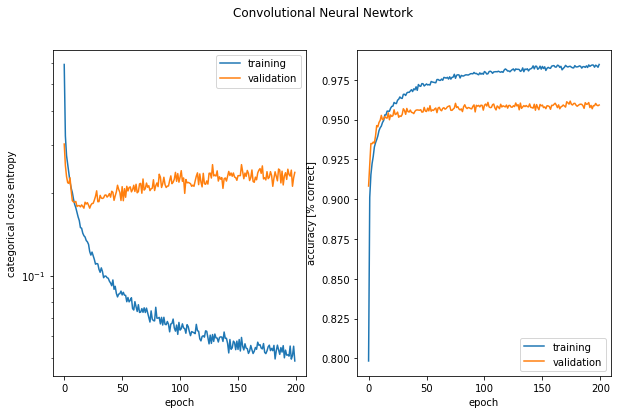

In [113]:
plot_history(history, 'Convolutional Neural Newtork')

Value with early stop:

In [114]:
# get minimium loss index
es_idx = history.history['val_loss'].index(min(history.history['val_loss']))
# store loss and accuracy with early stopping
loss = history.history['val_loss'][es_idx]
acc = history.history['val_acc'][es_idx]

print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 0.17639388001964257
Test accuracy: 0.956177924217463


**Configuration 2**

In [115]:
# 1st Stage
model = Sequential()
# Conv [32] -> Conv [32] -> Pool (with dropout on the pooling layer)
model.add(Conv2D(conv_depth_1, kernel_size=(kernel_size, kernel_size),
                 activation='relu', padding='same',
                 input_shape=input_shape))
model.add(Conv2D(conv_depth_1, (kernel_size, kernel_size), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(drop_prob_1))
# Conv [64] -> Conv [64] -> Pool (with dropout on the pooling layer)
model.add(Conv2D(conv_depth_2, (kernel_size, kernel_size), padding='same',activation='relu'))
model.add(Conv2D(conv_depth_2, (kernel_size, kernel_size), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(pool_size, pool_size)))
model.add(Dropout(drop_prob_1))

# 2nd Stage
model.add(Flatten())
model.add(Dense(hidden_size, activation='relu'))
model.add(Dropout(drop_prob_2))
model.add(Dense(5, activation='softmax'))

# compile
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

# fit
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=num_epochs,
          verbose=0,
          validation_data=(x_test, y_test))

# Evaluate with early stopping
es_idx = history.history['val_loss'].index(min(history.history['val_loss']))
# store loss and accuracy with early stopping
loss = history.history['val_loss'][es_idx]
acc = history.history['val_acc'][es_idx]

print('Test loss:', loss)
print('Test accuracy:', acc)

Test loss: 0.13677012373799155
Test accuracy: 0.9625041186200728


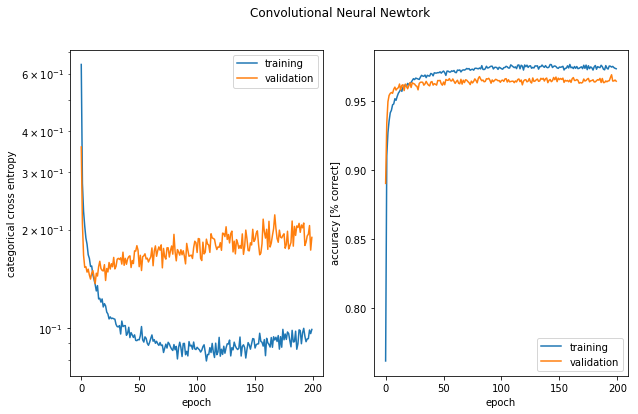

In [116]:
plot_history(history, 'Convolutional Neural Newtork')